In [21]:
import numpy as np
import pandas as pd

import re

import networkx as nx
%matplotlib ipympl
import matplotlib.pyplot as plt
%matplotlib ipympl

import osmnx as ox

#import geopandas as gpd
#import shapely.geometry
#import pickle
#import plotly.express as px

# Reading the full list

My first attempts with regex were a bit too complex:

In [5]:
# draft/pseudo-function
#def bsd_txt_to_df(txt_file):
#     df_address_gather = pd.DataFrame(columns=['address_id', 'door_num', 'street_side', 'sub_street', 'street', 'off_street', 'to_street', 'part_of_street', 'intersects', 'occupant_last', 'occupant_first', 'occupation'])
#     for line in txt_file:
#         current_street = None
#         current_sub_street = None
        #if the line is followed by another line beginning 'See',
            #ignore both lines
        #if the line follows a blank line, is less than five words long, is followed by a line containing 'to' or 'Off', 
            #add it to column 'street' and update current_street to store it for use in the next houses
            #add the text on the following line after 'Off' or before 'to' in 'off_street'. Add text after 'to' to 'to_street'
        #if it begins '                    ',
            #add it to column 'sub_street' and update current_sub_street to store it for use in the next houses
        #if it begins with no or multiple spaces then a number,
            #strip spaces and '.' and store the number including up to one letter occuring before the '.' in 'door_num'
        #or if it starts with multiple spaces, store a NaN in 'door_num'
        #then from the same line, store in the same row the text up to the first comma in 'occupant_last', and after the last comma in 'occupation', and after the second comma in 'occupant_first'
        #or if the line starts with multpile '.' and contains 'intersects', store the rest of the text in 'intersects'
        #for each row store current_street in 'street' and current_sub_street in 'sub_street'
        #give each row a sequential 'address_id' of even numbers only
        #return df_address_gather
        
        
        #TODO: deal with [left side], [right side]

In [6]:
# function to read and use regex to recognise relationships
def bsd_txt_to_df(txt_file_path):
    #load file into memory
    with open(txt_file_path) as file:
        txt_file = file.readlines()
    df_address_gather = pd.DataFrame(columns=['address_id', 'door_num', 'street_side', 'sub_street', 'street', 'off_street', 'to_street', 'part_of_street', 'intersects', 'occupant_last', 'occupant_first', 'occupation'])
    current_street = current_sub_street = off_street = to_street = door_num = occupant_last = occupant_first = occupation = intersects = ''
    iter_txt_file = iter(txt_file)

    address_regex = r'^\s*(\d+[A-Za-z]?(?:\s*[\&\s]+\s*\d+[A-Za-z]?)?(?:[.\u00BD])?)?\s*' #TODO: fix
        
    for line in iter_txt_file:
        # store the next line for context
        next_line = next(iter_txt_file, '')
        
        # check if the line is a street heading and store if so
        if len(line.split()) < 5 and (' to ' in next_line or next_line.startswith('Off ')): #and not any(i.isdigit() for i in next_line) 
            current_street = line.strip()
            current_sub_street = ''
            #TODO: regex to store street Off and to values

        # check if line is a sub-street and store if so, place to current one if not
        elif line.startswith('                    '):
            current_sub_street = line.strip()

        # check for intersects
        elif 'intersects' in line.lower():
            intersects = line.strip()

        #TODO: check for house with door number (number and letter/&/half/comma followed by a dot) or no door number (some spaces?)
        # elif re.match(address_regex, line):
        #     parts = line.re()...... ## REDO
        #     door_num = parts[1].strip() if parts[1] else ''
        #     rest = parts[2].split(',', 2)
        #     occupant_last = rest[0].strip() if rest else ''
        #     if len(rest) > 1:
        #         rest_parts = rest[1].split(',', 1)
        #         occupant_first = rest_parts[0].strip()
        #         occupation = rest_parts[1].strip() if len(rest_parts) > 1 else ''
        #     else: occupation = occupant_first = ''

        # add line to df
        df_address_gather.loc[len(df_address_gather)] = {
            'address_id': len(df_address_gather) * 2, #add alternating IDs in case of squeezing things in sequence
            'street': current_street,
            'off_street': off_street,
            'to_street': to_street,
            'sub_street': current_sub_street,
            'door_num': door_num,
            'occupant_last': occupant_last,
            'occupant_first': occupant_first,
            'occupation': occupation,
            'intersects': intersects
        }
    return df_address_gather

df_addresses = bsd_txt_to_df('./data/1877-BSD')
df_addresses


,address_id,door_num,street_side,sub_street,street,off_street,to_street,part_of_street,intersects,occupant_last,occupant_first,occupation
0,0,,NaN,,Abbey Street,,,NaN,,,,
1,2,,NaN,,Abbey Street,,,NaN,,,,
2,4,,NaN,,Abbey Street,,,NaN,,,,
3,6,,NaN,,Abbey Street,,,NaN,,,,
4,8,,NaN,,Abbey Street,,,NaN,,,,
...,...,...,...,...,...,...,...,...,...,...,...,...
21594,43188,,NaN,,Zetland Street,,,NaN,..........York Lane intersects,,,
21595,43190,,NaN,,Zetland Street,,,NaN,..........York Lane intersects,,,
21596,43192,,NaN,,Zetland Street,,,NaN,..........York Lane intersects,,,
21597,43194,,NaN,,Zetland Street,,,NaN,..........York Lane intersects,,,


If regex is too cumbersome, I considered that an alternative might be to list all street endings. However, not all contain a standard ending, such as 'Bridge End' or 'Short Strand'.

In [7]:
# street_types = ['Street', 'Road', 'Entry', 'Court', 'Place', 'Terrace', 'Row', ]


As each address should be a node, I will instead first simply focus on extracing each line and storing the property of 'street':

In [8]:
# function to read lines as nodes and assign street headings as a property
def bsd_txt_to_df_basic_nodes(txt_file_path):
    #load file into memory
    with open(txt_file_path) as file:
        txt_file = file.readlines()
    iter_txt_file = iter(txt_file)
    df_node_gather = pd.DataFrame(columns=['street', 'node_info'])
    current_street = node_info = ''
           
    for line in iter_txt_file:

        if line.strip() == '':
            continue
        
        # check if the line is a street heading and store if so
        next_line = next(iter_txt_file, '') # store the next line for context if there is one
        if len(line.split()) < 5 and (' to ' in next_line or next_line.startswith('Off ')): #and not any(i.isdigit() for i in next_line) 
            current_street = line.strip()
            
        # check for intersects
        elif 'intersects' in line.lower():
            node_info = line.strip()
        
        #store anything else as node_info
        else:
            node_info = line #retaining whole line for now as formatting has clues

        # add line to df
        df_node_gather.loc[len(df_node_gather)] = {
            'street': current_street,
            'node_info': node_info
        }
    return df_node_gather

df_basic_nodes = bsd_txt_to_df_basic_nodes('./data/1877-BSD')
df_basic_nodes


,street,node_info
0,Abbey Street,
1,Abbey Street,"1. Donaldson, Wm.\n"
2,Abbey Street,"5. Ireland, Alex., flax dresser\n"
3,Abbey Street,"9. McIntosh, Wm., shoe maker\n"
4,Abbey Street,"13. Donnelly, John\n"
...,...,...
20528,Zetland Street,Six small houses\n
20529,Zetland Street,"20. Fetherston-H., William\n"
20530,Zetland Street,"14. Pritchard, Mrs.\n"
20531,Zetland Street,"6. Morrow, Mrs.\n"


Next I add a few more fields and rules:

In [9]:
def bsd_txt_to_df_basic_nodes(txt_file_path):
    with open(txt_file_path) as file:
        txt_file = file.readlines()

    df_node_gather = pd.DataFrame(columns=['street', 'side', 'node_info', 'node_type'])
    current_street = node_info = ''
    i = 0 

    while i < len(txt_file):
        line = txt_file[i]
        next_line = txt_file[i + 1] if i + 1 < len(txt_file) else '' #with EOF protection

        if line.strip() == '' or line.startswith('[Late ') or line.startswith('(Late '):
            i += 1
            continue
        
        # detect street based on next line contents and just assign to variable for now
        if len(line.split()) < 5 and not '[' in line \
            and (' to ' in next_line or next_line.startswith('Off ')) \
                and not any(char.isdigit() for char in next_line) and not ',' in next_line\
                    and not 'door to' in next_line and not 'entrance to' in next_line:
            if line.strip() == 'Mountpottinger' or line.strip() == 'Ballymacarrett': # crudely solve edge case of an extra line for district; skip back one line to get street
                line = txt_file[i -1]
            side = ''
            current_street = line.strip()
            node_info = next_line.strip()
            node_type = 'from-to'
            i += 1 # increment i an extra time to avoid processing next line twice
        
        # crude detect side 
        elif ']' in line:
            side = line.strip()
            i += 1
            continue

        # detect sub street and store the next line, its parent, as the street instead
        elif len(line.split()) < 5 and (next_line.startswith('See ')):
            current_street = next_line.replace('See ', '')
            node_info = line
            node_type = 'sub-street'
            i += 1  # increment i an extra time to avoid processing next line twice
        
        elif 'intersect' in line.lower():
            node_info = line.strip(".").replace(' intersects', '').replace(' intersect', '').replace('\n', '')
            node_type = 'intersect'
        
        else:
            node_info = line.strip()

        df_node_gather.loc[len(df_node_gather)] = {
            'street': current_street,
            'side': side,
            'node_info': node_info,
            'node_type': node_type
        }

        # reset per-record variables and increment
        node_info = node_type = ''
        i += 1

    return df_node_gather

df_basic_nodes = bsd_txt_to_df_basic_nodes('./data/1877-BSD')
df_basic_nodes


,street,side,node_info,node_type
0,Abbey Street,,North King Street to Peter's Hill,from-to
1,Abbey Street,,"1. Donaldson, Wm.",
2,Abbey Street,,"3. Craggan, John, musician",
3,Abbey Street,,"5. Ireland, Alex., flax dresser",
4,Abbey Street,,"7. Long, John",
...,...,...,...,...
38372,Zetland Street,,"14. Pritchard, Mrs.",
38373,Zetland Street,,"8. Clarke, James, her Majesty's Court of Probate",
38374,Zetland Street,,"6. Morrow, Mrs.",
38375,Zetland Street,,"4. Lynas, Joseph, boot maker",


In [14]:
df_basic_nodes.to_pickle

<bound method NDFrame.to_pickle of                street side                                         node_info  \
0        Abbey Street                      North King Street to Peter's Hill   
1        Abbey Street                                      1. Donaldson, Wm.   
2        Abbey Street                             3. Craggan, John, musician   
3        Abbey Street                        5. Ireland, Alex., flax dresser   
4        Abbey Street                                          7. Long, John   
...               ...  ...                                               ...   
38372  Zetland Street                                    14. Pritchard, Mrs.   
38373  Zetland Street       8. Clarke, James, her Majesty's Court of Probate   
38374  Zetland Street                                        6. Morrow, Mrs.   
38375  Zetland Street                           4. Lynas, Joseph, boot maker   
38376  Zetland Street                     2. Fleming, James, insurance agent   

    

Due to inconsistencies in formatting, the function does not yet capture all the data. However, it should suffice for graphing.

Here is an extract of the streets and intersections:

In [10]:
df_connections = df_basic_nodes[df_basic_nodes['node_type'].isin(['intersect', 'from-to'])][['street', 'node_type', 'node_info']]

df_connections[['from', 'to']] = df_connections['node_info'].str.split(' to ', n=1, expand=True)
df_connections['from'] = df_connections['from'].str.replace('Off ', '')
df_connections

,street,node_type,node_info,from,to
0,Abbey Street,from-to,North King Street to Peter's Hill,North King Street,Peter's Hill
53,Abbey Street West,from-to,St. Paul Street to Hanna Street,St. Paul Street,Hanna Street
60,Abbot Street,from-to,Off Peveril Street,Peveril Street,None
73,Abercorn Street,from-to,Claremont Street to Camden Street,Claremont Street,Camden Street
80,Abercorn Street North,from-to,Leeson Street to Grosvenor Street,Leeson Street,Grosvenor Street
...,...,...,...,...,...
38349,York Street,intersect,Frederick Street,Frederick Street,None
38356,York Street,intersect,York Lane,York Lane,None
38365,Young's Place,from-to,Off Newtownards Road,Newtownards Road,None
38367,Young's Row,from-to,Off Newtownards Road,Newtownards Road,None


In [11]:
df_nodes = df_basic_nodes.join(df_connections[['from', 'to']])
df_nodes

,street,side,node_info,node_type,from,to
0,Abbey Street,,North King Street to Peter's Hill,from-to,North King Street,Peter's Hill
1,Abbey Street,,"1. Donaldson, Wm.",,NaN,NaN
2,Abbey Street,,"3. Craggan, John, musician",,NaN,NaN
3,Abbey Street,,"5. Ireland, Alex., flax dresser",,NaN,NaN
4,Abbey Street,,"7. Long, John",,NaN,NaN
...,...,...,...,...,...,...
38372,Zetland Street,,"14. Pritchard, Mrs.",,NaN,NaN
38373,Zetland Street,,"8. Clarke, James, her Majesty's Court of Probate",,NaN,NaN
38374,Zetland Street,,"6. Morrow, Mrs.",,NaN,NaN
38375,Zetland Street,,"4. Lynas, Joseph, boot maker",,NaN,NaN


In [45]:
G = nx.Graph()

In [47]:
#test adding all points to graph (then later joining inital intersections)
for index, row in df_nodes.iterrows():
    street = row['street']
    node_type = row['node_type']
    node_info = row['node_info']

    if index > 0 and df_nodes.at[index - 1, 'street'] == street:
        G.add_edge(index, index-1, street=street, node_type=node_type, node_info=node_info)
    else:
        G.add_node(index, street=street, node_type=node_type, node_info=node_info)
    

In [61]:
#modified version of above
G = nx.Graph()

for index, row in df_nodes.iterrows():
    street = row['street']
    node_type = row['node_type']
    node_info = row['node_info']

    if index > 0 and df_nodes.at[index - 1, 'street'] == street:
        prev_node_id = f"{street}_{index-1}"
        node_id = f"{street}_{index}"
        G.add_edge(node_id, prev_node_id)

    else:
        node_id = f"{street}_{index}"
        G.add_node(node_id, street=street, node_type=node_type, node_info=node_info)
        
list(G.nodes(data=True))

[('Abbey Street_0',
  {'street': 'Abbey Street',
   'node_type': 'from-to',
   'node_info': "North King Street to Peter's Hill"}),
 ('Abbey Street_1', {}),
 ('Abbey Street_2', {}),
 ('Abbey Street_3', {}),
 ('Abbey Street_4', {}),
 ('Abbey Street_5', {}),
 ('Abbey Street_6', {}),
 ('Abbey Street_7', {}),
 ('Abbey Street_8', {}),
 ('Abbey Street_9', {}),
 ('Abbey Street_10', {}),
 ('Abbey Street_11', {}),
 ('Abbey Street_12', {}),
 ('Abbey Street_13', {}),
 ('Abbey Street_14', {}),
 ('Abbey Street_15', {}),
 ('Abbey Street_16', {}),
 ('Abbey Street_17', {}),
 ('Abbey Street_18', {}),
 ('Abbey Street_19', {}),
 ('Abbey Street_20', {}),
 ('Abbey Street_21', {}),
 ('Abbey Street_22', {}),
 ('Abbey Street_23', {}),
 ('Abbey Street_24', {}),
 ('Abbey Street_25', {}),
 ('Abbey Street_26', {}),
 ('Abbey Street_27', {}),
 ('Abbey Street_28', {}),
 ('Abbey Street_29', {}),
 ('Abbey Street_30', {}),
 ('Abbey Street_31', {}),
 ('Abbey Street_32', {}),
 ('Abbey Street_33', {}),
 ('Abbey Street_34',

I can see that the basis of my graph has been formed. Let's explore further. 

In [62]:
G.number_of_nodes()

38377

In [63]:
G.number_of_edges()

36973

In [64]:
list(G.edges(data=True))

[('Abbey Street_0', 'Abbey Street_1', {}),
 ('Abbey Street_1', 'Abbey Street_2', {}),
 ('Abbey Street_2', 'Abbey Street_3', {}),
 ('Abbey Street_3', 'Abbey Street_4', {}),
 ('Abbey Street_4', 'Abbey Street_5', {}),
 ('Abbey Street_5', 'Abbey Street_6', {}),
 ('Abbey Street_6', 'Abbey Street_7', {}),
 ('Abbey Street_7', 'Abbey Street_8', {}),
 ('Abbey Street_8', 'Abbey Street_9', {}),
 ('Abbey Street_9', 'Abbey Street_10', {}),
 ('Abbey Street_10', 'Abbey Street_11', {}),
 ('Abbey Street_11', 'Abbey Street_12', {}),
 ('Abbey Street_12', 'Abbey Street_13', {}),
 ('Abbey Street_13', 'Abbey Street_14', {}),
 ('Abbey Street_14', 'Abbey Street_15', {}),
 ('Abbey Street_15', 'Abbey Street_16', {}),
 ('Abbey Street_16', 'Abbey Street_17', {}),
 ('Abbey Street_17', 'Abbey Street_18', {}),
 ('Abbey Street_18', 'Abbey Street_19', {}),
 ('Abbey Street_19', 'Abbey Street_20', {}),
 ('Abbey Street_20', 'Abbey Street_21', {}),
 ('Abbey Street_21', 'Abbey Street_22', {}),
 ('Abbey Street_22', 'Abbey S

In [ ]:
nx.draw(G, with_labels=False)
plt.show()

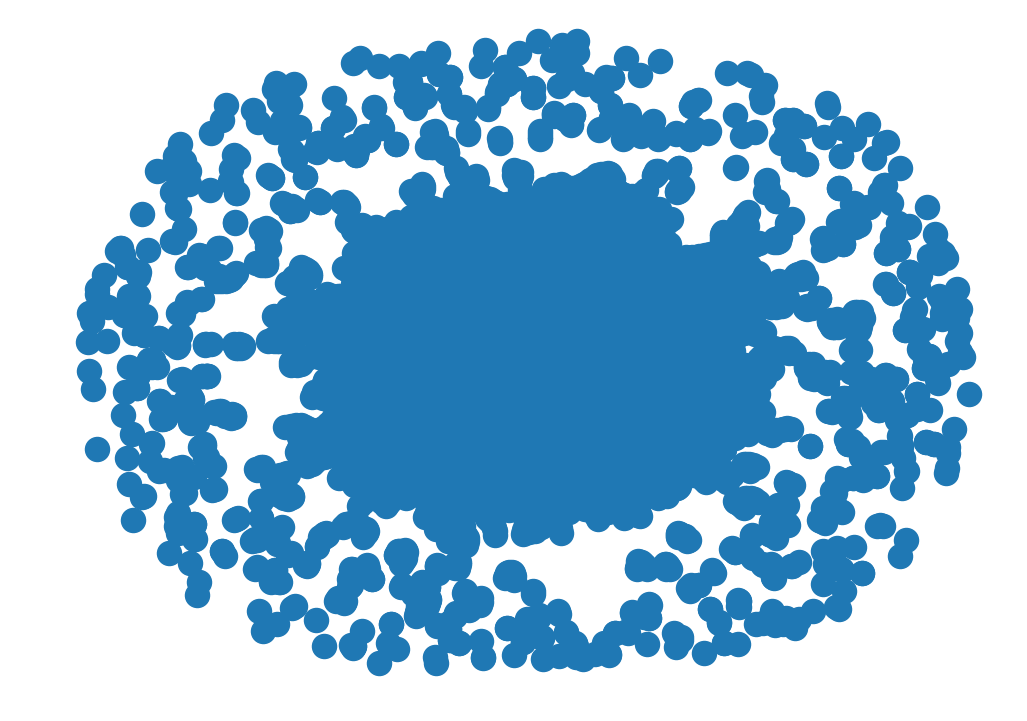

In [50]:
#note: not spring layout doesn't make much sense as lines are not yet connected
pos = nx.spring_layout(G, seed=8)  
nx.draw(G, pos=pos, with_labels=False)
plt.show()

In [ ]:
# # handle intersect rows?
# for index, row in df_nodes.iterrows():
#     if row['node_type'] == 'intersect':
#         partner_nodes = df_nodes[(df_nodes['street'] == row['street']) & (df_nodes['node_info'] == row['node_info'])].index.tolist()
#         for partner_index in partner_nodes:
#             if index != partner_index:
#                 # TODO: change this to overlap properly - currently merging nodes by adding an edge
#                 G.add_edge(index, partner_index)

I think I need better visualistaion tools before I can check my graph structure. I will therefore move on to using OSMnx earlier than intended. I don't yet have any spatial data but maybe it's possible to use the visualisation tools already.

# OSMnx

# Abandoned approaches

## Reading just the street list containing single connections

In [19]:
# def bsd_txt_to_intersections_basic(street_file_path):
#     with open(street_file_path) as file:
#         streets = file.readlines()
    
#     df_intersection_gather = pd.DataFrame(columns=['street_id', 'street_name', 'off_street_name'])
        
#     for line in streets:
#         if ', see ' in line:
#             continue # ignore sub-streets for now
#         elif ', ' in line:
#             df_intersection_gather.loc[len(df_intersection_gather)] = {
#                 'street_id': len(df_intersection_gather),
#                 'street_name': line.split(', ')[0],
#                 'off_street_name': line.split(', ')[1].strip()
#             }

#     return df_intersection_gather

# df_off_street = bsd_txt_to_intersections_basic('./data/1877-BSD-streets-only')
# df_off_street

,street_id,street_name,off_street_name
0,0,Abbey Street,Peter's Hill
1,1,Abbey Street West,St. Paul Street
2,2,Abbot Street,Peveril Street
3,3,Abercorn Basin,Queen's Quay
4,4,Abercorn Cottages,Ballymacarrett
...,...,...,...
1180,1180,York Street,Donegall Street
1181,1181,York Street Little,Patrick Street Great
1182,1182,Young's Place,Newtownards Road
1183,1183,Young's Row,Ballymacarrett


/tmp/ipykernel_26143/393047237.py:5: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  binary_matrix = pd.crosstab(df['street_name'], df['off_street_name']).applymap(lambda x: 1 if x > 0 else 0)


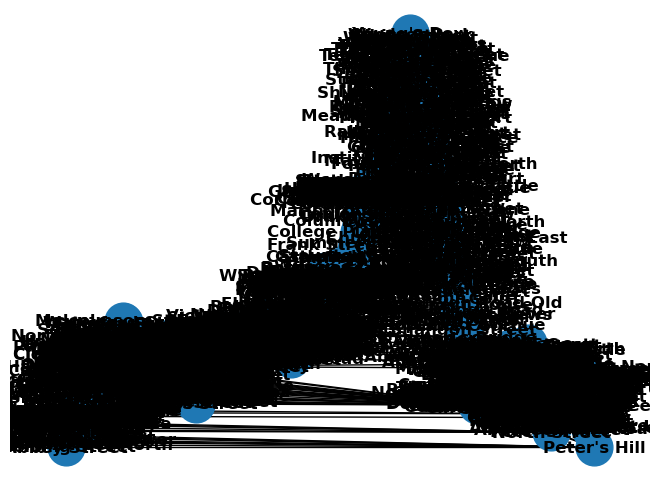

In [20]:
df = df_off_street
df.drop('street_id', axis=1, inplace=True)

# use crosstab to make a format compatible with adjacency matrix of NetworkX
binary_matrix = pd.crosstab(df['street_name'], df['off_street_name']).applymap(lambda x: 1 if x > 0 else 0)

# make sure it's square (ie all values are in x and y)
binary_matrix = binary_matrix.reindex(columns=df['street_name'].unique(), fill_value=0)

# create graph object
G = nx.from_pandas_adjacency(binary_matrix)

# Draw the graph
pos = nx.planar_layout(G)
nx.draw(G, pos, with_labels=True, font_weight='bold', node_size=700)

# Show the graph
plt.show() #TODO: check interaction between nx.draw and plt.show


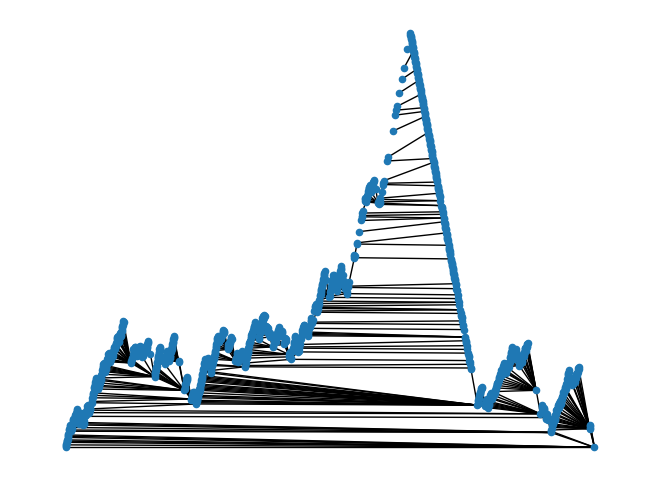

In [44]:
nx.draw_planar(G, with_labels=False, font_weight='bold', node_size=20)


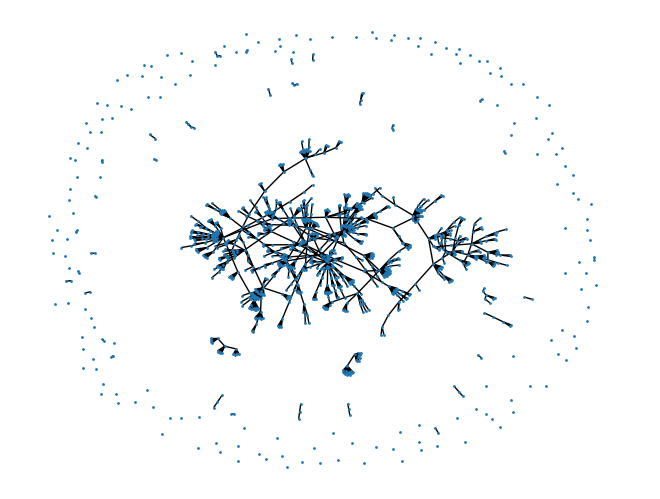

In [37]:
nx.draw(G, with_labels=False, font_weight='bold', node_size=1)
#plt.show()

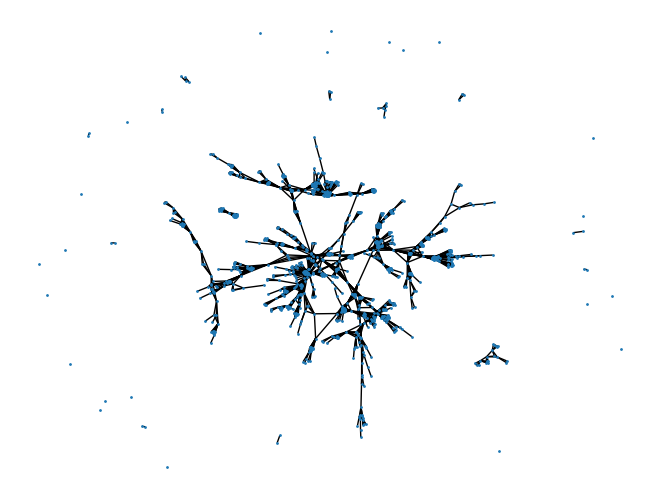

In [50]:
L=nx.line_graph(G)
nx.draw(L, node_size=1)


''The Node identifiers in your graph are the strings (e.g., 'NP'). Since you can't have two different nodes with the same identifier, different instances of the same string collide. You can solve it by separating the node's identifier and node's string. Keep a unique integer to identify each node, and map it to the appropriate string.'' https://stackoverflow.com/questions/53997298/allowing-duplicate-nodes-in-networkx-preventing-a-node-from-having-two-parents

## Too much regex, too soon